In [1]:
import numpy as np
import glob
import pickle
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import matplotlib
import matplotlib
import matplotlib as mpl
import matplotlib.patches as mpatches
from matplotlib.colors import Normalize
import matplotlib.lines as mlines
import os
import os.path as osp

In [2]:
with open('./Results_exp/ctrgcn_infact_plus_2d_primitive_schedLincos/eval.pkl', 'rb') as f:
    ctrgcn_2d = pickle.load(f)

gt_labels = np.array([i['gt_label'].item() for i in ctrgcn_2d])
pred_labels = np.array([i['pred_label'].item() for i in ctrgcn_2d])
pred_feats = np.array([i['pred_feats'].numpy() for i in ctrgcn_2d])

with open('./Data/InfAct_plus/2d/primitive/InfAct_plus.pkl', 'rb') as f:
    infact_ds = pickle.load(f)

frame_dirs = [item for item in infact_ds['split']['val']]

D23_indices = [("D02" in item or "D03" in item) for item in frame_dirs]

D23_frame_dirs = [fd for fd, b in zip(frame_dirs,D23_indices) if b]
gt_labels_D23 = gt_labels[D23_indices]
pred_labels_D23 = pred_labels[D23_indices]
pred_feats_D23 = pred_feats[D23_indices]

assert len(D23_frame_dirs)==len(gt_labels_D23)
assert len(D23_frame_dirs)==len(pred_labels_D23)

In [3]:

POSTURE_LABEL2IDS = {'Supine': 0, 'Prone': 1, 'Sitting': 2, 'Standing': 3, 'All-fours': 4}
POSTURE_IDS2LABEL = {v:k for k,v in POSTURE_LABEL2IDS.items()}

def get_acc(gts, preds):
    assert len(preds)==len(gts), 'Predictions and Ground truths lenghts are incompatible'
    return (preds==gts).sum()/len(gts)

def plot_cm(gts, preds, ax=None):
    acc = get_acc(gts, preds)
    labels = list(POSTURE_IDS2LABEL.values())
    cm = ConfusionMatrixDisplay.from_predictions(y_true=gts, y_pred=preds, normalize='true', display_labels=labels, ax=ax, values_format='.2f', cmap='Blues')
    cm.ax_.set_title(f"Accuracy: {acc*100:.2f}%")
    return cm

def compress_latents(latents, compressor_method=PCA, ax=None):
    compressor = compressor_method(n_components=2)
    pred_feats = compressor.fit_transform(latents)
    return pred_feats

def set_ax_borders(ax, top, right, bottom, left):
    ax.spines['top'].set_visible(top)
    ax.spines['right'].set_visible(right)
    ax.spines['bottom'].set_visible(bottom)
    ax.spines['left'].set_visible(left)

def autopct_format(values):
    def my_format(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{:.1f}%\n({v:d})'.format(pct, v=val)
    return my_format

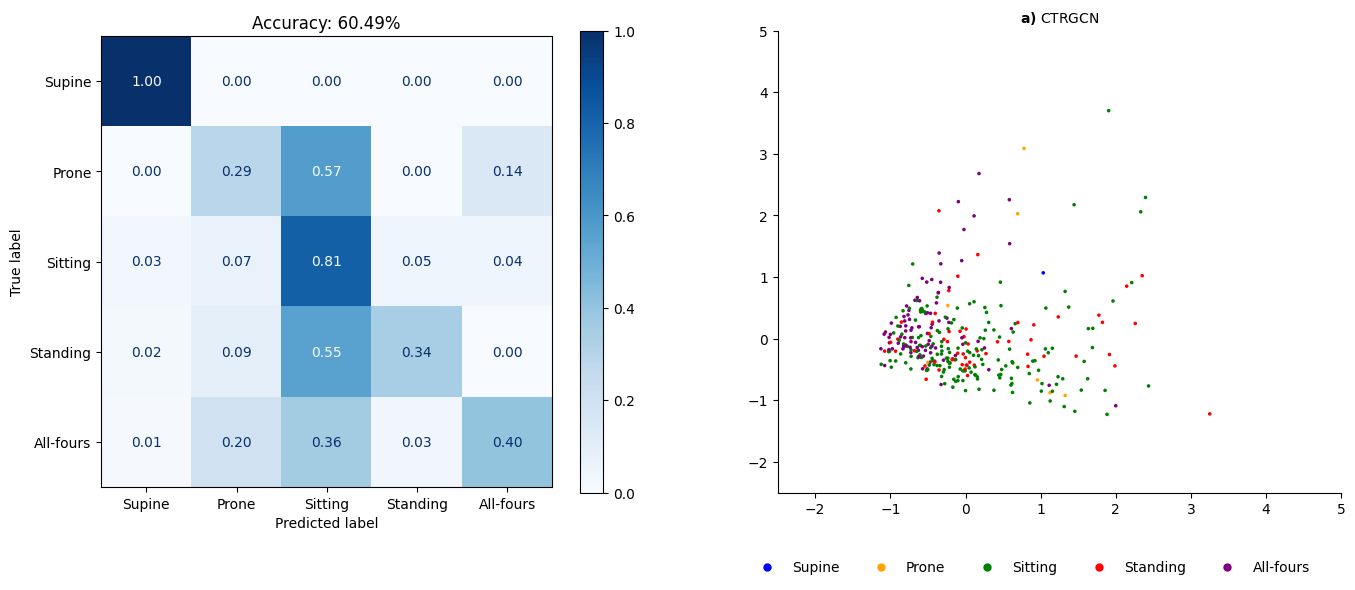

In [4]:
COLORS = ['blue', 'orange', 'green', 'red', 'purple']
CLASS_LABELS = ['Supine', 'Prone', 'Sitting', 'Standing',  'All-fours']

fig, axes = plt.subplots(ncols=2)
fig.set_size_inches(16,6)

latents = compress_latents(pred_feats_D23, compressor_method=PCA)

plot_cm(gt_labels_D23, pred_labels_D23, ax=axes[0])
axes[1].set_title(r"$\bf{a)}$ CTRGCN", fontsize=10)
axes[1].scatter(latents[:,0], latents[:,1], c = gt_labels_D23, cmap=matplotlib.colors.ListedColormap(COLORS), s=10, marker='.')
axes[1].set_xlim(-2.5, 5)
axes[1].set_ylim(-2.5, 5)
set_ax_borders(axes[1], False, False, True, True)

handles = []
for i, label in enumerate(CLASS_LABELS):
    l = mlines.Line2D([], [], color=COLORS[i], marker='.', linestyle='None',
                            markersize=10, label=f"{label}")
    handles.append(l)

plt.legend(loc='upper center', bbox_to_anchor=(0.45, -0.12),
          fancybox=False, shadow=False, ncol=6, handles=handles, frameon=False)
plt.savefig('./ctrgcn_cm+latents.png')


In [5]:
D02_clips = glob.glob("./Data/D02_clips/*/*.avi")
D02_clips = [osp.basename(pth) for pth in D02_clips]
D02_clips_faulties = [n for n in D02_clips if n[0]=="_"]

D03_clips = glob.glob("./Data/D03_clips/*/*.avi")
D03_clips = [osp.basename(pth) for pth in D03_clips]
D03_clips_faulties = [n for n in D03_clips if n[0]=="_"]

all_clips = [*D02_clips,*D03_clips]
all_clips_faulties = [*D02_clips_faulties,*D03_clips_faulties]

Text(0.5, 1.0, 'D03 error ratio: 54.80%')

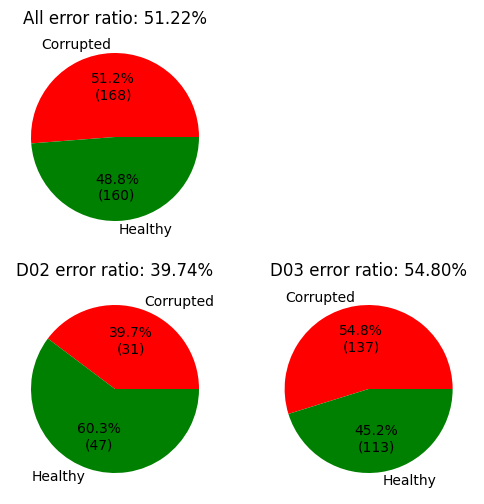

In [6]:
fig, axes = plt.subplots(ncols=2, nrows=2)
fig.set_size_inches(6,6)
axes = axes.flatten()

axes[0].pie((len(all_clips_faulties),len(all_clips)-len(all_clips_faulties)), colors=['r', 'g'], labels=['Corrupted', 'Healthy'], 
            autopct=autopct_format((len(all_clips_faulties),len(all_clips)-len(all_clips_faulties))))
axes[0].set_title(f"All error ratio: {(len(all_clips_faulties)/len(all_clips))*100:.2f}%")

axes[1].set_axis_off()

axes[2].pie((len(D02_clips_faulties),len(D02_clips)-len(D02_clips_faulties)), colors=['r', 'g'], labels=['Corrupted', 'Healthy'],
            autopct=autopct_format((len(D02_clips_faulties),len(D02_clips)-len(D02_clips_faulties))))
axes[2].set_title(f"D02 error ratio: {(len(D02_clips_faulties)/len(D02_clips))*100:.2f}%")

axes[3].pie((len(D03_clips_faulties),len(D03_clips)-len(D03_clips_faulties)), colors=['r', 'g'], labels=['Corrupted', 'Healthy'],
            autopct=autopct_format((len(D03_clips_faulties),len(D03_clips)-len(D03_clips_faulties))))
axes[3].set_title(f"D03 error ratio: {(len(D03_clips_faulties)/len(D03_clips))*100:.2f}%")

In [7]:
dir_info = []
for fd, gt, pred in zip(D23_frame_dirs, gt_labels_D23, pred_labels_D23):
    list_ = fd.split("_")
    subject = list_[0]
    vid_name = list_[1]+"_"+list_[2]
    pos_info = list_[-1]
    assert "Posture" in pos_info
    pos_num = int(pos_info.split(" ")[-1])
    dir_info.append({"subject": subject, "vid_name": vid_name, "pos_num": pos_num, "pred": pred, "gt": gt})

new_dir_info = []
for info in dir_info:
    new_info = info.copy()
    same_vids = [i for i in dir_info if( new_info["subject"]==i["subject"] and new_info["vid_name"]==i["vid_name"])]
    assert len(same_vids)>=1
    new_pos_num=0
    for vid in same_vids:
        if vid["pos_num"]!=new_info["pos_num"]:
            new_pos_num+=1
        else:
            break
    new_info["pos_num"] = new_pos_num
    new_dir_info.append(new_info)

dir_info = new_dir_info.copy()

In [8]:
clip_info = []
for clip in all_clips:
    if clip in D02_clips:
        subject="D02"
    else:
        subject="D03"
    if clip[0]=="_":
        clip_=clip[1:]
        faulty=True
    else:
        clip_=clip
        faulty=False
    list_ = clip_.split("_")
    vid_name = list_[1]+"_"+list_[2]
    pos_num = int(list_[-2])
    clip_info.append({"subject": subject, "vid_name": vid_name, "pos_num": pos_num, "faulty": faulty})

In [9]:
combined_info = []
for info in clip_info:
    matched_info = [n_info for n_info in dir_info 
                    if (info["subject"]==n_info["subject"] and info["vid_name"]==n_info["vid_name"] and info["pos_num"]==n_info["pos_num"])]
    if len(matched_info)!=1:
        print(info)
    

In [10]:
combined_info = []
for info in dir_info:
    matched_info = [n_info for n_info in clip_info 
                    if (info["subject"]==n_info["subject"] and info["vid_name"]==n_info["vid_name"] and info["pos_num"]==n_info["pos_num"])]
    if len(matched_info)!=1:
        print(info)
        continue
    combined_info.append({**info, **matched_info[0]})

{'subject': 'D03', 'vid_name': 'nooie_20230118-151749@300000', 'pos_num': 11, 'pred': 4, 'gt': 4}


In [11]:
faulty_false = 0
faulty_true = 0
corrent_true = 0
corrent_false = 0
for info in combined_info:
    gt = info["gt"]
    pred = info["pred"]
    faulty = info["faulty"]
    if gt==pred and not faulty:
        corrent_true+=1
    if gt==pred and faulty:
        faulty_true+=1
    if gt!=pred and not faulty:
        corrent_false+=1
    if gt!=pred and faulty:
        faulty_false+=1
assert faulty_false+faulty_true+corrent_true+corrent_false==len(combined_info)

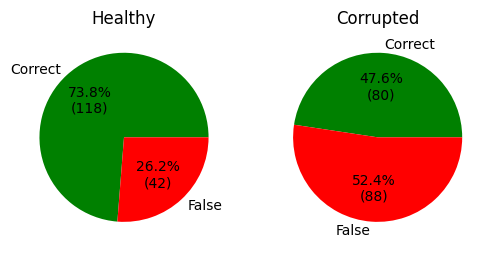

In [12]:
fig, axes = plt.subplots(ncols=2, nrows=1)
fig.set_size_inches(6,6)
axes = axes.flatten()

axes[0].set_title("Healthy")
axes[0].pie((corrent_true,corrent_false), colors=['g', 'r'], labels=['Correct', 'False'], 
            autopct=autopct_format((corrent_true,corrent_false)))

axes[1].set_title("Corrupted")
axes[1].pie((faulty_true,faulty_false), colors=['g', 'r'], labels=['Correct', 'False'], 
            autopct=autopct_format((faulty_true,faulty_false)))

plt.show()